# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.53KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

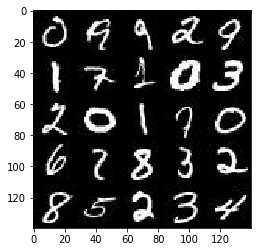

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

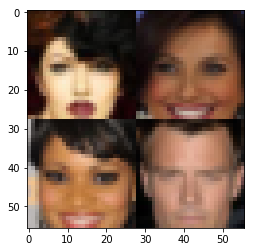

In [3]:
show_n_images = 5

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    #parameters
    kernel_size = 5
    alpha = 0.2
    
#     print("images_shape:", images.shape)
    
    with tf.variable_scope("discriminator", reuse=reuse) as discriminator_scope:
        #input shape is 28x28x5
        input_layer1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same')
        relu1 = tf.maximum(alpha * input_layer1, input_layer1) 
        #shape is now 14x14x64
        
        input_layer2 = tf.layers.conv2d(input_layer1, 128, kernel_size, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(input_layer2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        #shape is now 7x7x128
        
        input_layer3 = tf.layers.conv2d(input_layer2, 256, kernel_size, strides=1, padding='same')
        batch_norm3 = tf.layers.batch_normalization(input_layer3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3) 
        #shape is now 7x7x256
        
        #flatten?
#         flat = tf.reshape(relu3,(-1,28*28*256))
        flat = tf.reshape(relu3,(-1,7*7*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 
    kernel_size = 5
    
#     print("z.shape", z.get_shape())
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z,7*7*512)
        #reshape for the conv network
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         print("x1", x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256,kernel_size, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         print("x2", x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128,kernel_size, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         print("x3", x3.get_shape())
        
        #output
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same')
#         print("logits", logits.get_shape())
        
        out = tf.tanh(logits)
        
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #implementing pattern described in deep-leraning/dcgan-svhn model_loss
    generator_object = generator(input_z, out_channel_dim, True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_object, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get weights and biases variables to update
    training_variables = tf.trainable_variables()
    d_variables = [v for v in training_variables if v.name.startswith("discriminator")]
    g_variables = [v for v in training_variables if v.name.startswith("generator")]
    
    #optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_variables)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_variables)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import pickle as pkl

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #model inputs
    _, img_width, img_height, img_channels = data_shape
    inputs_real, inputs_z, lr = model_inputs(img_width,img_height,img_channels, z_dim)
    #calc loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z,img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
#                 print("batch_images shape: ", batch_images.shape)
                x = batch_images*2
                batch_count += 1
#                 print("Running epoch:",epoch_i+1, " batch: ", batch_count)
                
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: x, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: x})
                
                if(batch_count % 10 == 0):
                    train_loss_d = d_loss.eval({inputs_real: x, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.6f}...".format(train_loss_d),
                          "Generator Loss: {:.6f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if (batch_count % 100 == 0):
                    show_generator_output(sess, 25, inputs_z, img_channels, data_image_mode)
                
            saver.save(sess, './checkpoints/generator.ckpt')

    return losses

                
                

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.621293... Generator Loss: 0.292111
Epoch 1/2... Discriminator Loss: 1.800974... Generator Loss: 0.247993
Epoch 1/2... Discriminator Loss: 1.862401... Generator Loss: 0.244447
Epoch 1/2... Discriminator Loss: 1.510497... Generator Loss: 0.389617
Epoch 1/2... Discriminator Loss: 1.374280... Generator Loss: 0.495377
Epoch 1/2... Discriminator Loss: 1.290194... Generator Loss: 0.611286
Epoch 1/2... Discriminator Loss: 1.305690... Generator Loss: 0.650574
Epoch 1/2... Discriminator Loss: 1.502622... Generator Loss: 0.569022
Epoch 1/2... Discriminator Loss: 1.528582... Generator Loss: 0.579245
Epoch 1/2... Discriminator Loss: 1.652668... Generator Loss: 0.579493


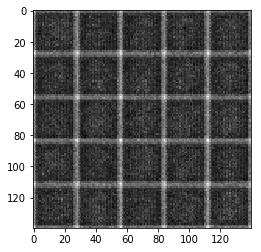

Epoch 1/2... Discriminator Loss: 1.744808... Generator Loss: 0.583160
Epoch 1/2... Discriminator Loss: 1.721584... Generator Loss: 0.581563
Epoch 1/2... Discriminator Loss: 1.680035... Generator Loss: 0.613162
Epoch 1/2... Discriminator Loss: 1.663454... Generator Loss: 0.625685
Epoch 1/2... Discriminator Loss: 1.559770... Generator Loss: 0.656764
Epoch 1/2... Discriminator Loss: 1.509265... Generator Loss: 0.667532
Epoch 1/2... Discriminator Loss: 1.403081... Generator Loss: 0.725636
Epoch 1/2... Discriminator Loss: 1.435901... Generator Loss: 0.687472
Epoch 1/2... Discriminator Loss: 1.369741... Generator Loss: 0.693614
Epoch 1/2... Discriminator Loss: 1.487570... Generator Loss: 0.626312


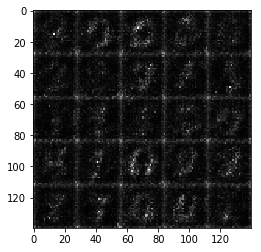

Epoch 1/2... Discriminator Loss: 1.534742... Generator Loss: 0.608084
Epoch 1/2... Discriminator Loss: 1.529887... Generator Loss: 0.594196
Epoch 1/2... Discriminator Loss: 1.434607... Generator Loss: 0.648118
Epoch 1/2... Discriminator Loss: 1.443138... Generator Loss: 0.659654
Epoch 1/2... Discriminator Loss: 1.465324... Generator Loss: 0.665237
Epoch 1/2... Discriminator Loss: 1.466010... Generator Loss: 0.644539
Epoch 1/2... Discriminator Loss: 1.435966... Generator Loss: 0.648763
Epoch 1/2... Discriminator Loss: 1.475391... Generator Loss: 0.642717
Epoch 1/2... Discriminator Loss: 1.441439... Generator Loss: 0.662730
Epoch 1/2... Discriminator Loss: 1.437784... Generator Loss: 0.652271


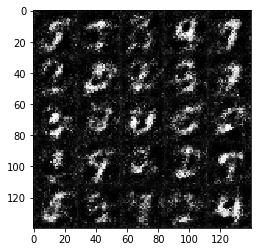

Epoch 1/2... Discriminator Loss: 1.427969... Generator Loss: 0.694899
Epoch 1/2... Discriminator Loss: 1.457392... Generator Loss: 0.653279
Epoch 1/2... Discriminator Loss: 1.409316... Generator Loss: 0.698913
Epoch 1/2... Discriminator Loss: 1.399934... Generator Loss: 0.692924
Epoch 1/2... Discriminator Loss: 1.431583... Generator Loss: 0.677352
Epoch 1/2... Discriminator Loss: 1.404660... Generator Loss: 0.676672
Epoch 1/2... Discriminator Loss: 1.405291... Generator Loss: 0.677946
Epoch 1/2... Discriminator Loss: 1.403213... Generator Loss: 0.692745
Epoch 1/2... Discriminator Loss: 1.352943... Generator Loss: 0.713134
Epoch 1/2... Discriminator Loss: 1.372848... Generator Loss: 0.704722


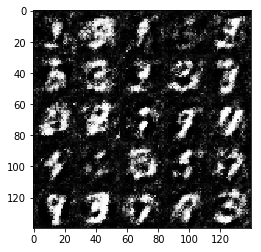

Epoch 1/2... Discriminator Loss: 1.393990... Generator Loss: 0.691532
Epoch 1/2... Discriminator Loss: 1.410644... Generator Loss: 0.684617
Epoch 1/2... Discriminator Loss: 1.395916... Generator Loss: 0.690306
Epoch 1/2... Discriminator Loss: 1.357770... Generator Loss: 0.721261
Epoch 1/2... Discriminator Loss: 1.349546... Generator Loss: 0.727268
Epoch 1/2... Discriminator Loss: 1.386418... Generator Loss: 0.698982
Epoch 2/2... Discriminator Loss: 1.343852... Generator Loss: 0.732159
Epoch 2/2... Discriminator Loss: 1.377786... Generator Loss: 0.694709
Epoch 2/2... Discriminator Loss: 1.372229... Generator Loss: 0.714485
Epoch 2/2... Discriminator Loss: 1.369281... Generator Loss: 0.697136


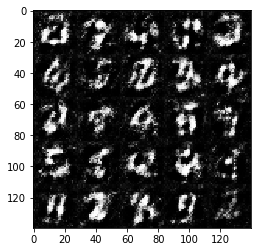

Epoch 2/2... Discriminator Loss: 1.340729... Generator Loss: 0.721347
Epoch 2/2... Discriminator Loss: 1.344202... Generator Loss: 0.724104
Epoch 2/2... Discriminator Loss: 1.323662... Generator Loss: 0.753351
Epoch 2/2... Discriminator Loss: 1.342685... Generator Loss: 0.728930
Epoch 2/2... Discriminator Loss: 1.317794... Generator Loss: 0.706948
Epoch 2/2... Discriminator Loss: 1.332886... Generator Loss: 0.726659
Epoch 2/2... Discriminator Loss: 1.330088... Generator Loss: 0.722479
Epoch 2/2... Discriminator Loss: 1.348754... Generator Loss: 0.721581
Epoch 2/2... Discriminator Loss: 1.340406... Generator Loss: 0.738082
Epoch 2/2... Discriminator Loss: 1.281666... Generator Loss: 0.756108


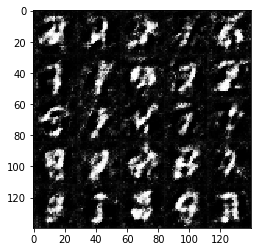

Epoch 2/2... Discriminator Loss: 1.344762... Generator Loss: 0.718752
Epoch 2/2... Discriminator Loss: 1.335686... Generator Loss: 0.714252
Epoch 2/2... Discriminator Loss: 1.345160... Generator Loss: 0.737382
Epoch 2/2... Discriminator Loss: 1.311710... Generator Loss: 0.728946
Epoch 2/2... Discriminator Loss: 1.321943... Generator Loss: 0.730151
Epoch 2/2... Discriminator Loss: 1.326151... Generator Loss: 0.723887
Epoch 2/2... Discriminator Loss: 1.314312... Generator Loss: 0.750280
Epoch 2/2... Discriminator Loss: 1.314786... Generator Loss: 0.730794
Epoch 2/2... Discriminator Loss: 1.313038... Generator Loss: 0.750864
Epoch 2/2... Discriminator Loss: 1.316156... Generator Loss: 0.717687


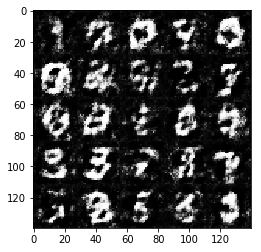

Epoch 2/2... Discriminator Loss: 1.324352... Generator Loss: 0.742911
Epoch 2/2... Discriminator Loss: 1.309986... Generator Loss: 0.732253
Epoch 2/2... Discriminator Loss: 1.306118... Generator Loss: 0.711529
Epoch 2/2... Discriminator Loss: 1.332180... Generator Loss: 0.753352
Epoch 2/2... Discriminator Loss: 1.273179... Generator Loss: 0.746720
Epoch 2/2... Discriminator Loss: 1.328017... Generator Loss: 0.711749
Epoch 2/2... Discriminator Loss: 1.280635... Generator Loss: 0.777845
Epoch 2/2... Discriminator Loss: 1.305904... Generator Loss: 0.753090
Epoch 2/2... Discriminator Loss: 1.343063... Generator Loss: 0.738840
Epoch 2/2... Discriminator Loss: 1.271393... Generator Loss: 0.753339


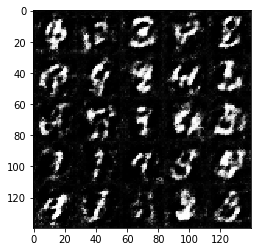

Epoch 2/2... Discriminator Loss: 1.313272... Generator Loss: 0.726350
Epoch 2/2... Discriminator Loss: 1.246498... Generator Loss: 0.765329
Epoch 2/2... Discriminator Loss: 1.281414... Generator Loss: 0.758824
Epoch 2/2... Discriminator Loss: 1.250446... Generator Loss: 0.794394
Epoch 2/2... Discriminator Loss: 1.241259... Generator Loss: 0.783372
Epoch 2/2... Discriminator Loss: 1.295624... Generator Loss: 0.757556
Epoch 2/2... Discriminator Loss: 1.247959... Generator Loss: 0.816818
Epoch 2/2... Discriminator Loss: 1.297427... Generator Loss: 0.766927
Epoch 2/2... Discriminator Loss: 1.244057... Generator Loss: 0.796249
Epoch 2/2... Discriminator Loss: 1.278973... Generator Loss: 0.743407


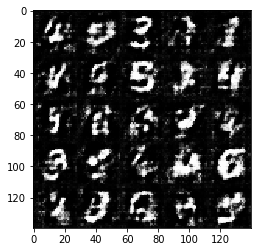

Epoch 2/2... Discriminator Loss: 1.241490... Generator Loss: 0.778003
Epoch 2/2... Discriminator Loss: 1.275515... Generator Loss: 0.740751
Epoch 2/2... Discriminator Loss: 1.245705... Generator Loss: 0.836735


In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.928111... Generator Loss: 0.223360
Epoch 1/1... Discriminator Loss: 1.925886... Generator Loss: 0.239366
Epoch 1/1... Discriminator Loss: 2.524360... Generator Loss: 0.120712
Epoch 1/1... Discriminator Loss: 2.539620... Generator Loss: 0.121337
Epoch 1/1... Discriminator Loss: 2.699771... Generator Loss: 0.100827
Epoch 1/1... Discriminator Loss: 2.391207... Generator Loss: 0.145563
Epoch 1/1... Discriminator Loss: 2.013037... Generator Loss: 0.211773
Epoch 1/1... Discriminator Loss: 1.722968... Generator Loss: 0.303755
Epoch 1/1... Discriminator Loss: 1.749726... Generator Loss: 0.316069
Epoch 1/1... Discriminator Loss: 1.691654... Generator Loss: 0.332183


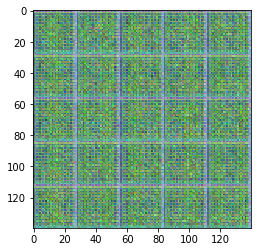

Epoch 1/1... Discriminator Loss: 1.767887... Generator Loss: 0.371771
Epoch 1/1... Discriminator Loss: 1.794279... Generator Loss: 0.407966
Epoch 1/1... Discriminator Loss: 1.802075... Generator Loss: 0.426497
Epoch 1/1... Discriminator Loss: 1.754490... Generator Loss: 0.432366
Epoch 1/1... Discriminator Loss: 1.749812... Generator Loss: 0.477402
Epoch 1/1... Discriminator Loss: 1.603705... Generator Loss: 0.534900
Epoch 1/1... Discriminator Loss: 1.690743... Generator Loss: 0.563680
Epoch 1/1... Discriminator Loss: 1.483483... Generator Loss: 0.623806
Epoch 1/1... Discriminator Loss: 1.461141... Generator Loss: 0.639987
Epoch 1/1... Discriminator Loss: 1.611623... Generator Loss: 0.625643


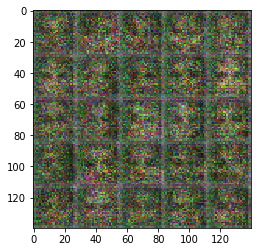

Epoch 1/1... Discriminator Loss: 1.654450... Generator Loss: 0.569058
Epoch 1/1... Discriminator Loss: 1.715865... Generator Loss: 0.545295
Epoch 1/1... Discriminator Loss: 1.894776... Generator Loss: 0.562355
Epoch 1/1... Discriminator Loss: 1.817700... Generator Loss: 0.575794
Epoch 1/1... Discriminator Loss: 1.836005... Generator Loss: 0.591713
Epoch 1/1... Discriminator Loss: 1.872080... Generator Loss: 0.602450
Epoch 1/1... Discriminator Loss: 1.938975... Generator Loss: 0.606756
Epoch 1/1... Discriminator Loss: 1.958350... Generator Loss: 0.594014
Epoch 1/1... Discriminator Loss: 1.934355... Generator Loss: 0.601067
Epoch 1/1... Discriminator Loss: 1.882787... Generator Loss: 0.587047


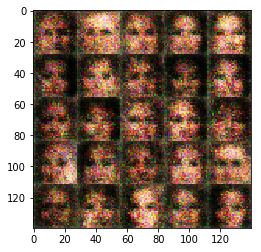

Epoch 1/1... Discriminator Loss: 1.887744... Generator Loss: 0.588554
Epoch 1/1... Discriminator Loss: 1.918741... Generator Loss: 0.555874
Epoch 1/1... Discriminator Loss: 1.908878... Generator Loss: 0.568824
Epoch 1/1... Discriminator Loss: 1.996401... Generator Loss: 0.564581
Epoch 1/1... Discriminator Loss: 1.879765... Generator Loss: 0.570493
Epoch 1/1... Discriminator Loss: 1.922714... Generator Loss: 0.553685
Epoch 1/1... Discriminator Loss: 1.939931... Generator Loss: 0.525502
Epoch 1/1... Discriminator Loss: 1.889149... Generator Loss: 0.525751
Epoch 1/1... Discriminator Loss: 1.855441... Generator Loss: 0.545134
Epoch 1/1... Discriminator Loss: 1.869159... Generator Loss: 0.560547


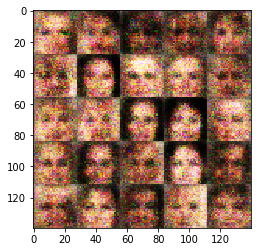

Epoch 1/1... Discriminator Loss: 1.801698... Generator Loss: 0.547189
Epoch 1/1... Discriminator Loss: 1.798440... Generator Loss: 0.554319
Epoch 1/1... Discriminator Loss: 1.814528... Generator Loss: 0.559528
Epoch 1/1... Discriminator Loss: 1.785236... Generator Loss: 0.545642
Epoch 1/1... Discriminator Loss: 1.799420... Generator Loss: 0.573597
Epoch 1/1... Discriminator Loss: 1.785963... Generator Loss: 0.571528
Epoch 1/1... Discriminator Loss: 1.780764... Generator Loss: 0.538536
Epoch 1/1... Discriminator Loss: 1.774529... Generator Loss: 0.572191
Epoch 1/1... Discriminator Loss: 1.755937... Generator Loss: 0.583893
Epoch 1/1... Discriminator Loss: 1.715410... Generator Loss: 0.596517


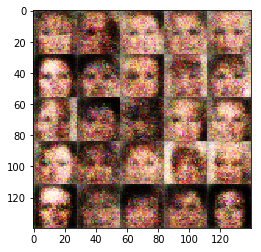

Epoch 1/1... Discriminator Loss: 1.711399... Generator Loss: 0.580859
Epoch 1/1... Discriminator Loss: 1.694826... Generator Loss: 0.573057
Epoch 1/1... Discriminator Loss: 1.688050... Generator Loss: 0.571231


KeyboardInterrupt: 

In [54]:
batch_size = 256
z_dim = 60
learning_rate = 0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.